# Get FAPAR data using openEO

Fraction of Absorbed Photosynthetically Active Radiation (FAPAR) a key biophysical variable describing the fraction of incoming solar radiation absorbed by green and living vegetation elements for photosynthesis. It is recognized as an Essential Climate Variable (ECV) by the Global Climate Observing System (GCOS) and is widely used in climate monitoring, ecosystem assessment, and land surface modelling.

In this notebook, we will demonstrate how to access and process FAPAR data using the openEO API in the Copernicus Data Space Ecosystem (CDSE). Two main approaches will be covered: (i) accessing the operational FAPAR product and (ii) computing FAPAR on demand using the BioPAR openEO service.


Within the Copernicus Data Space Ecosystem (CDSE), FAPAR can be accessed either as an operational land product or computed on demand from satellite observations using openEO predefined processes. This notebook focuses on both approaches and shows how they can be used side by side through openEO.

All processing is executed in the cloud on the CDSE infrastructure using openEO API, so no local data download or heavy computation is required. Therefore, if you don't yet have an account on CDSE, please register at [https://dataspace.copernicus.eu](https://dataspace.copernicus.eu)


In this notebook, you will learn how to:
* Connect to the CDSE openEO federation backend
* Directly access the [Copernicus Global Land Service](https://land.copernicus.eu/en/products/vegetation) FAPAR collection hosted by [Terrascope](https://documentation.dataspace.copernicus.eu/APIs/openEO/federation/openeo_federation.html#terrascope)
* Compute FAPAR on demand using the BioPAR openEO service
* Run EO processing workflows entirely in the cloud and download only the final results

Prerequisites
* A CDSE account (register at https://dataspace.copernicus.eu)
* Basic familiarity with Python and Earth Observation data 

## Introduction

Before we jump into the practical steps, let's briefly understand what is openEO and the concepts involved in accessing FAPAR data.

### What is openEO?

openEO is an open-source standard that simplifies access to and processing of Earth Observation (EO) data.
Instead of downloading and processing large satellite datasets locally, openEO allows users to:
* Access EO data directly where it is stored
* Run scalable processing workflows in the cloud
* Save workflows as User-Defined Processes (UDPs) such as the BioPAR service for FAPAR computation
* Reshare and reuse UDPs as services

This enables faster, more reproducible, and easier-to-scale EO data analysis.

### openEO workflows

Before using the BioPAR openEO service, it is useful to understand the general structure of an openEO workflow.

Most openEO workflows follow the same high-level pattern:
1. Connect to an openEO backend
2. Load collection for a specific spatial and temporal extent
3. Build a processing workflow (also called a *process graph*) using openEO processes
4. Execute the workflow on the backend

For a full introduction to these concepts, please refer to the official openEO *Getting Started* notebook:  
https://github.com/Open-EO/openeo-community-examples/blob/main/python/1.%20GettingStarted/GettingStarted.ipynb


### openEO User-Defined Processes and Services

While building workflows many times from scratch can be tedious, openEO supports the creation of reusable processing chains. 

Such workflows can be encapsulated as **User-Defined Processes (UDPs)** and shared as **services**. These services:
- Hide the complexity of the underlying processing workflow
- Require fewer inputs from the user
- Ensure consistent and reproducible results

The **BioPAR openEO service** is one such service. It encompasses a comprehensive processing workflow for deriving biophysical vegetation parameters from Sentinel-2 data.

Let's get started by installing the required Python package.

## Installation

The only package required to run this service is the `openeo` Python client, which can be installed via pip:

```

pip install openeo

```

In [1]:
import openeo

Next, let's set up a connection to an openEO backend, in this case the Copernicus Data Space Ecosystem (CDSE) federation. 

*Don't get confused by the term "federation" here; it simply is referring to a group service providers in the ecosystem. Since are interested in collection hosted by Terrascope, we are using the federation endpoint. To connect to CDSE backend use "openeo.dataspace.copernicus.eu"* 

For more information visit:
* [Documentation](https://documentation.dataspace.copernicus.eu/APIs/openEO/federation/openeo_federation.html)
* [Federated processing example](https://github.com/Open-EO/openeo-community-examples/blob/main/python/Federation/FederatedProcessing.ipynb)


You can authenticate using your credentials as shown below.

In [2]:
connection = openeo.connect("openeofed.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


### Method 1: Accessing operational FAPAR product from Copernicus Global Land Service

The first method demonstrates how to load the global FAPAR product, CGLS_FAPAR300_V1_GLOBAL. Let us first identify the available collection for the FAPAR product. We can do this by listing all available collections and filtering for those related to FAPAR.

In [11]:
collections = connection.list_collections()

for collection in collections:
    title = collection.get("title", "")
    cid = collection.get("id", "")
    if "FAPAR" in title or "FAPAR" in cid:
        print(f"ID: {cid}, Title: {title}")


ID: CGLS_FAPAR300_V1_GLOBAL, Title: Copernicus Global Land fAPAR product V1, 300m resolution, 10-daily
ID: TERRASCOPE_S2_FAPAR_V2, Title: Sentinel-2 FAPAR, last 2 years over Europe + selected areas, by Terrascope.
ID: CGLS_FAPAR_V2_GLOBAL, Title: Copernicus Global Land FAPAR product V2, 1km resolution, 10-daily


In [4]:
connection.describe_collection("CGLS_FAPAR_V2_GLOBAL")

{'cube:dimensions': {'bands': {'type': 'bands', 'values': ['FAPAR']},
  't': {'extent': ['1999-01-01T00:00:00Z', '2020-06-30T00:00:00Z'],
   'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180.00446428571428, 179.9955357],
   'reference_system': 4326,
   'step': 0.008928571428584,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-59.9955357, 80.0044643],
   'reference_system': 4326,
   'step': 0.008928571428569,
   'type': 'spatial'}},
 'description': 'Global FAPAR at 1km resolution, 10-daily. The FAPAR quantifies the fraction of the solar radiation absorbed by live leaves for the photosynthesis activity. Then, it refers only to the green and alive elements of the canopy. The FAPAR depends on the canopy structure, vegetation element optical properties, atmospheric conditions, and angular configuration. To overcome this latter dependency, a daily integrated FAPAR value is assessed.\n\nFAPAR is recognized as an Essential Climate Variable (ECV) by the Global Climate Observing System (GCOS).',
 'extent': {'spatial': {'bbox': [[-180.00446428571428,
     -59.9955357,
     179.9955357,
     80.0044643]]},
  'temporal': {'interval': [['1999-01-01T00:00:00Z',
     '2020-06-30T00:00:00Z']]}},
 'id': 'CGLS_FAPAR_V2_GLOBAL',
 'license': 'free',
 'links': [{'href': 'https://land.copernicus.eu/global/products/fapar',
   'rel': 'alternate',
   'title': 'Product web page.'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'root'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'parent'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections/CGLS_FAPAR_V2_GLOBAL',
   'rel': 'self'}],
 'stac_extensions': ['https://stac-extensions.github.io/datacube/v2.2.0/schema.json',
  'https://stac-extensions.github.io/eo/v1.1.0/schema.json'],
 'stac_version': '0.9.0',
 'summaries': {'federation:backends': ['terrascope']},
 'title': 'Copernicus Global Land FAPAR product V2, 1km resolution, 10-daily'}

Copernicus Global Land FAPAR V2 provides global FAPAR data at 1km spatial resolution and 10-day temporal resolution covering the period from 1999 to June 2020 from SPOT/VEGETATION and PROBA-V data. Detailed product information, including scientific background, algorithm description, and validation reports, is available on the Copernicus Land Monitoring Service vegetation products webpage at https://land.copernicus.eu/en/products/vegetation.

In the following cell, we load the FAPAR collection for a specific area of interest and temporal extent.

In [5]:
fapar_1km = connection.load_collection(
    "CGLS_FAPAR_V2_GLOBAL",
    temporal_extent=["2019-01-01", "2019-02-01"],
    spatial_extent={"west": 5.215759, "south": 51.160296, "east": 5.405960, "north": 51.244815},
    bands=["FAPAR"],
)

As openEO follows a lazy execution model, no processing is done yet. We have just defined the data we want to work with. As a user you can now build more complex processing workflows using openEO processes. Advance usecases using openEO for EO data processing can be found in the [openEO community examples repository](https://github.com/Open-EO/openeo-community-examples/tree/main/python)

In this example, we will keep it simple and just create a job to download the data. For more information on openEO batch jobs, please refer to the [openEO documentation](https://open-eo.github.io/openeo-python-client/batch_jobs.html).

In [6]:
job = fapar_1km.create_job(out_format="GTiff", title="FAPAR_1km_Job")
job.start_and_wait()

0:00:00 Job 'terrascope-j-2601270950474e719a1104c48d21e034': send 'start'
0:00:11 Job 'terrascope-j-2601270950474e719a1104c48d21e034': created (progress 0%)
0:00:16 Job 'terrascope-j-2601270950474e719a1104c48d21e034': queued (progress 0%)
0:00:23 Job 'terrascope-j-2601270950474e719a1104c48d21e034': queued (progress 0%)
0:00:31 Job 'terrascope-j-2601270950474e719a1104c48d21e034': queued (progress 0%)
0:00:41 Job 'terrascope-j-2601270950474e719a1104c48d21e034': queued (progress 0%)
0:00:54 Job 'terrascope-j-2601270950474e719a1104c48d21e034': queued (progress 0%)
0:01:10 Job 'terrascope-j-2601270950474e719a1104c48d21e034': running (progress 9.1%)
0:01:29 Job 'terrascope-j-2601270950474e719a1104c48d21e034': running (progress 11.7%)
0:01:53 Job 'terrascope-j-2601270950474e719a1104c48d21e034': finished (progress 100%)


<BatchJob job_id='terrascope-j-2601270950474e719a1104c48d21e034'>

Once a batch job is finished you can get a handle to the results (which can be a single file or multiple files) and download them to a local directory.

In [7]:
results = job.get_results()
results.download_files("data/fapar_1km")

[PosixPath('data/fapar_1km/openEO_2019-01-10Z.tif'),
 PosixPath('data/fapar_1km/openEO_2019-01-20Z.tif'),
 PosixPath('data/fapar_1km/openEO_2019-01-31Z.tif'),
 PosixPath('data/fapar_1km/job-results.json')]

### Method 2: On-demand FAPAR computation with BioPAR UDP

The second method presented in this notebook is the on-demand computation of FAPAR using the BioPAR openEO service. 

As mentioned earlier, the BioPAR openEO service is a reusable processing component (called a User-Defined Process, or UDP). It isprovided by VITO/Terrascope through the [Copernicus Data Space Ecosystem (CDSE)](https://marketplace-portal.dataspace.copernicus.eu/catalogue/app-details/21) and the [APEx Algorithm Catalogue](https://algorithm-catalogue.apex.esa.int/apps/biopar#biophysical-parameters) for on-demand computation of the following biophysical parameters:
* LAI - Leaf Area Index
* FAPAR - Fraction of Absorbed Photosynthetically Active Radiation
* FCOVER - Fraction of Vegetation Cover
* CWC - Canopy Water Content
* CCC - Canopy Chlorophyll Content
  
The service:
* Uses Sentinel-2 Level-2A data from CDSE
* Performs cloud masking
* Applies validated BioPAR retrieval models
* Returns ready-to-use biophysical products


To compute a specific product from the BioPAR service, we call the BioPAR process through an active openEO connection, which returns a datacube containing the requested data. In this case, it requires:
- `biopar_type`: The type of biophysical parameter to compute (e.g., 'FAPAR', 'FCOVER', 'LAI', 'CCC', 'CWC').
- `temporal_extent`: The time range for which the data is requested.
- `spatial_extent`: The area of interest. It can be a feature collection or bounding box coordinates.

The namespace parameter references a publicly accessible JSON file that defines the process graph for the BIOPAR algorithm. This graph summarizes all the steps the service performs on Sentinel-2 data to derive the requested parameter.

In [8]:
# Create a processing graph from the BIOPAR process using an active openEO connection
fapar_biopar = connection.datacube_from_process(
        "biopar", 
        namespace = "https://raw.githubusercontent.com/ESA-APEx/apex_algorithms/refs/heads/main/algorithm_catalog/vito/biopar/openeo_udp/biopar.json",
        temporal_extent = ["2020-05-06", "2020-05-30"],
        spatial_extent= {"west": 5.215759, "south": 51.160296, "east": 5.405960, "north": 51.244815},
        biopar_type = 'FAPAR'
        )

In [9]:
job = fapar_biopar.create_job(out_format="GTiff", title="BIOPAR_FAPAR_Job")
job.start_and_wait()

0:00:00 Job 'cdse-j-26012710075148af933aea6b1942ad10': send 'start'
0:00:14 Job 'cdse-j-26012710075148af933aea6b1942ad10': created (progress 0%)
0:00:19 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:00:26 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:00:34 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:00:44 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:00:57 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:01:12 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:01:32 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:01:56 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:02:26 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:03:04 Job 'cdse-j-26012710075148af933aea6b1942ad10': running (progress N/A)
0:03:51 Job 'cdse-j-26012710075148af933aea6b1942ad10': finished (progress 1

<BatchJob job_id='cdse-j-26012710075148af933aea6b1942ad10'>

Though the example demonstrates FAPAR computation, the same approach can be used to compute other parameters like FCOVER, [LAI](./LAI.ipynb), CCC and CWC by changing the `biopar_type` parameter.

In [10]:
results = job.get_results()
results.download_files("data/fapar_biopar")

[PosixPath('data/fapar_biopar/openEO_2020-05-07Z.tif'),
 PosixPath('data/fapar_biopar/openEO_2020-05-12Z.tif'),
 PosixPath('data/fapar_biopar/openEO_2020-05-15Z.tif'),
 PosixPath('data/fapar_biopar/openEO_2020-05-17Z.tif'),
 PosixPath('data/fapar_biopar/openEO_2020-05-20Z.tif'),
 PosixPath('data/fapar_biopar/openEO_2020-05-25Z.tif'),
 PosixPath('data/fapar_biopar/openEO_2020-05-27Z.tif'),
 PosixPath('data/fapar_biopar/job-results.json')]

## Quick visualization

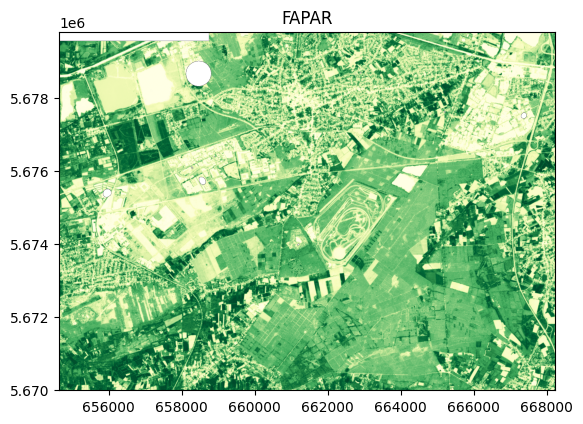

In [12]:
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

tif_file = "data/fapar_biopar/openEO_2020-05-07Z.tif"

with rasterio.open(tif_file) as src:
    data = src.read(1)
    extent = rasterio.plot.plotting_extent(src)

plt.imshow(data, cmap="YlGn", extent=extent)
plt.title("FAPAR")
plt.show()


Therefore, by using any of these approaches either the operational Copernicus land product access and on-demand FAPAR computation, user can obtain FAPAR data for their area and time of interest. Together, these workflows illustrate how openEO can be used as a unified interface supporting reproducible, scalable land and climate monitoring applications.